In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('dark')

# ====== Scikit-learn imports ======

from sklearn.svm import SVC
from sklearn.metrics import (
    auc,
    roc_curve,
    ConfusionMatrixDisplay,
    f1_score,
    balanced_accuracy_score,
)
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

# ====== Qiskit imports ======

from qiskit.circuit.library import ZZFeatureMap
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_algorithms.optimizers import COBYLA, NFT, SLSQP

## ====== Torch imports ======
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from lightning.pytorch.utilities.types import OptimizerLRScheduler
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader

import lightning, lightning.pytorch.loggers


In [2]:
df = pd.read_csv("C:/Users/8J6010897/Documents/GitHub/ISMB/data/GSE116237_forQ.csv")
labels = pd.read_csv("C:/Users/8J6010897/Documents/GitHub/ISMB/data/GSE116237 filtered labels.csv")
labels.drop('Unnamed: 0', axis=1, inplace=True)
labels.columns = ['Cells', 'Labels']
labels_filtered = labels[labels['Cells'].isin(list(df['Cells']))]
labels_filtered['Labels'] = [x.split(' ')[1] for x in labels_filtered['Labels']]
df = pd.merge(df, labels_filtered, on='Cells', how='inner')
df['Labels'] = df['Labels'].map({'T0': 0, 'phase2': 1})
y = np.array(df['Labels'])
X = df[df.columns[1:-1]].values

num_samples = X.shape[0]
num_feats = X.shape[1]
output_dim = 10

C:\Users\8J6010897\AppData\Local\Temp\ipykernel_81408\1421692985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_filtered['Labels'] = [x.split(' ')[1] for x in labels_filtered['Labels']]


In [14]:
print(num_feats)

2001


In [3]:
embedder = torch.nn.Sequential(
            nn.Linear(num_feats,256),
            nn.LeakyReLU(),
            nn.Linear(256,64),
            nn.LeakyReLU(),
            nn.Linear(64,32), 
            nn.LeakyReLU(),
            nn.Linear(32,16), 
            nn.LeakyReLU(),
            nn.Linear(16,output_dim),
            nn.LeakyReLU(), 
            ) 

classifier = torch.nn.Sequential(
            nn.Linear(output_dim,1),
            nn.Softmax(dim=1)
            )
class BinaryClassifierModel(lightning.LightningModule):
    def __init__(self, embedder, classifier, input_dim,learning_rate=1e-3):
        super().__init__()
        # self.fc1 = nn.Linear(input_dim, 264)
        # self.fc2 = nn.Linear(264, 128)
        # self.fc3 = nn.Linear(128, 64)
        # self.fc4 = nn.Linear(64, 8)
        # self.fc5 = nn.Linear(8,4)
        # self.fc6 = nn.Linear(4,1)
        self.input_dim = input_dim
        self.embedder = embedder
        self.classifier = classifier
        
        self.learning_rate = learning_rate
        self.loss_fun = nn.BCELoss()   
    # def forward(self, x):
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = F.relu(self.fc3(x))
    #     x = F.relu(self.fc4(x))
    #     x = F.relu(self.fc5(x))
    #     return F.softmax(self.fc6(x), dim=1)
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=32)  # No shuffling for validation
    
    def forward(self, X): 
        x = self.embedder(X)
        x = self.classifier(x) 
        return x 
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1)
        y_float = y.float()
        x_embedder = self.embedder(x)
        y_hat = self.classifier(x_embedder)
        #y_hat = torch.argmax(y_hat, dim=1)
        loss = self.loss_fun(y_hat, y_float)
        self.log("train_loss", loss, 
                prog_bar=True, 
                logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1)
        y_float = y.float()
        x_embedder = self.embedder(x)
        y_hat = self.classifier(x_embedder)
        val_loss = self.loss_fun(y_hat, y_float)
        f1score = f1_score(y_hat, y)
        print(f1score)
        #print(val_loss)
        self.log("val_loss", val_loss, prog_bar=False, logger=True)  # Log on epoch end
        return val_loss

        
    def configure_optimizers(self):
        return torch.optim.Adam(self.classifier.parameters(), lr=self.learning_rate)

        

In [4]:
def prepare_data(X_train, y_train, X_val, y_val):
    # Assuming X and y are NumPy arrays

    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                        torch.tensor(y_train, dtype=torch.float32))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                        torch.tensor(y_val, dtype=torch.float32))
    
    return train_data, val_data 

In [5]:
f1s = []
embeddings_train = []
embeddings_test = []
num_iter = 1
for i in range(num_iter): 

    X_working, X_held_out, y_working, y_held_out = train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        shuffle=True)

    X_train, X_test, y_train, y_test = train_test_split(X_working,
                                                        y_working,
                                                        train_size=0.9,
                                                        shuffle=True)

    num_epochs = 40
    model = BinaryClassifierModel(embedder, classifier, input_dim=num_feats)
    model.train_data, model.val_data = prepare_data(X_train, y_train, X_test, y_test)  # Prepare data for training
    logger = lightning.pytorch.loggers.TensorBoardLogger(save_dir=".",name="original_classifier")
    # Train the model
    trainer = lightning.Trainer(max_epochs=num_epochs, 
                                logger=logger)  # Adjust progress bar refresh rate as needed
    trainer.fit(model)
    model.eval()
    embedded_test = model.embedder(torch.tensor(X_held_out, dtype=torch.float32))
    y_pred = model.classifier(embedded_test)
    #y_pred = model(torch.tensor(X_held_out, dtype=torch.float32))
    y_pred_proba = y_pred.detach().cpu().numpy()
    y_pred_class = np.round(y_pred_proba)

    f1 = f1_score(y_held_out, y_pred_class)
    f1s.append(f1)
    
    embedded_train = model.embedder(torch.tensor(X_working, dtype=torch.float32)).detach().numpy()
    embeddings_train.append(embedded_train)
    embeddings_test.append(embedded_test.detach().numpy())
    

print("Mean F1 score: ", np.mean(f1s))
embedded_train = embeddings_train[0]
embedded_test = embeddings_test[0]
svc = SVC()
svc_vanilla = svc.fit(embedded_train, y_working)
labels_vanilla = svc_vanilla.predict(embedded_test)
f1_svc = f1_score(y_held_out, labels_vanilla, average='micro')
print("SVC: " + str(f1_svc))

    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: .\original_classifier

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | embedder   | Sequential | 531 K  | train
1 | classifier | Sequential | 11     | train
2 | loss_fun   | BCELoss    | 0      | train
--------------------------------------------------
531 K     Trainable params
0         Non-trainable params
531 K     Total params
2.127     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\8J6010897\AppData\Local\anaconda3\envs\new\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


0.6666666666666666
                                                                           

c:\Users\8J6010897\AppData\Local\anaconda3\envs\new\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\8J6010897\AppData\Local\anaconda3\envs\new\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 9/9 [00:00<00:00, 76.44it/s, v_num=0, train_loss=33.30] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 9/9 [00:00<00:00, 68.57it/s, v_num=0, train_loss=33.30]
Mean F1 score:  0.6545454545454545
SVC: 0.6891891891891891


In [79]:
print(np.mean(f1s))
c = 10 
embedded_train = embeddings_train[0]
embedded_test = embeddings_test[0]
svc = SVC(C=c)
svc_vanilla = svc.fit(embedded_train, y_working)
labels_vanilla = svc_vanilla.predict(embedded_test)
f1_svc = f1_score(y_held_out, labels_vanilla, average='micro')
print("SVC: " + str(f1_svc))


0.6545454545454545
SVC: 0.6486486486486487


In [80]:
service = QiskitRuntimeService(instance="ibm-q-ccf/cleveland-access/wl-protein") 
backend = service.least_busy(simulator=False, operational=True) 
#backend = AerSimulator(method='statevector')
algorithm_globals.random_seed = 12345
feature_map = ZZFeatureMap(feature_dimension=num_feats, 
                                reps=3, 
                                entanglement='linear', 
                                insert_barriers=True)
sampler = Sampler() 
fidelity = ComputeUncompute(sampler=sampler)
Qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
qsvc = SVC(kernel=Qkernel.evaluate, C=c)
qsvc_model = qsvc.fit(embedded_train, y_working)
labels_qsvc = qsvc_model.predict(embedded_test)
f1_qsvc = f1_score(y_held_out, labels_qsvc, average='micro')

print("QSVC: " + str(f1_qsvc))

QSVC: 0.6351351351351351


## VQC

In [81]:
num_features = output_dim

feature_map = ZZFeatureMap(feature_dimension=num_features, 
                        reps=3, 
                        entanglement='linear')
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

In [82]:
ansatz = RealAmplitudes(num_qubits=output_dim, reps=3)
#ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [83]:
optimizer = COBYLA(maxiter=100)
sampler = Sampler() 

from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


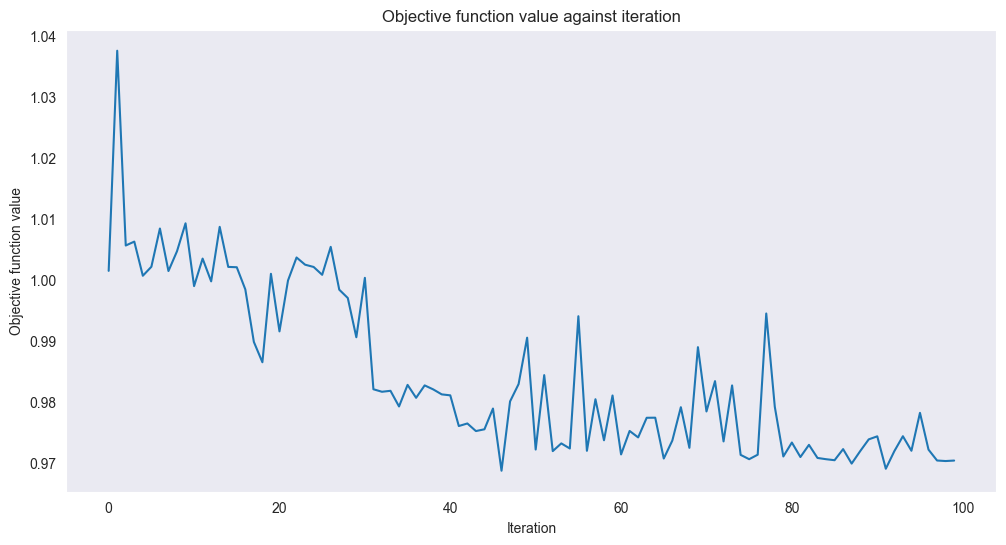

Training time: 808 seconds


In [84]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

sampler = Sampler(options={"shots": 5000})
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(embedded_train, y_working)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [85]:
train_score_q4 = vqc.score(embedded_train, y_working)
test_score_q4 = vqc.score(embedded_test, y_held_out)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")



Quantum VQC on the training dataset: 0.58
Quantum VQC on the test dataset:     0.49


# QNN (EstimatorQNN and SamplerQNN)

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

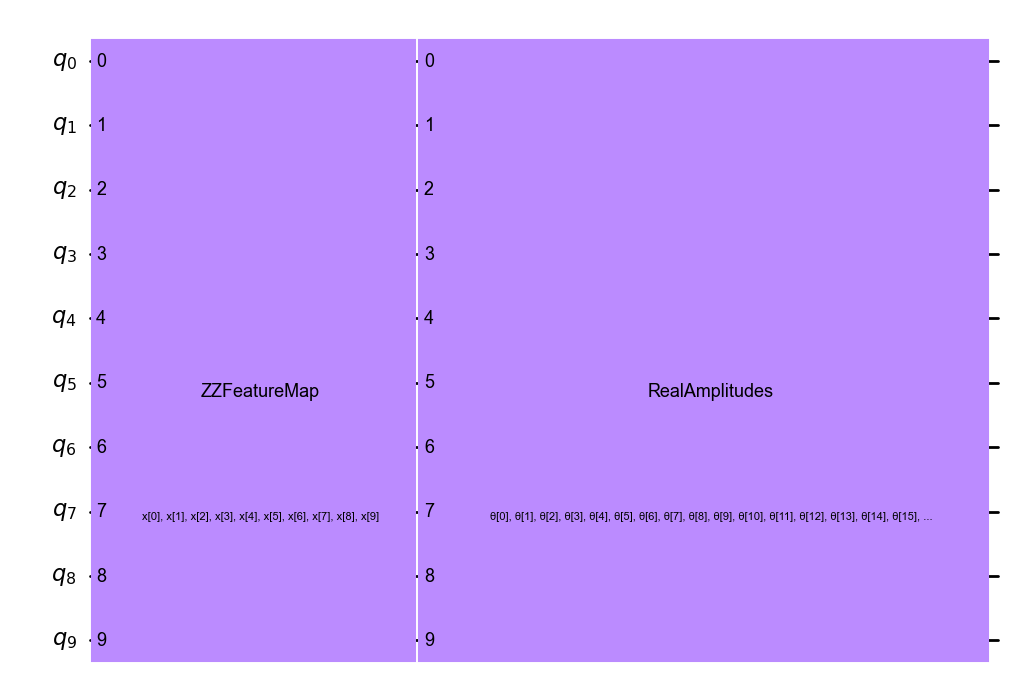

In [87]:
# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
qc_qnn = QNNCircuit(num_qubits=num_features)
qc_qnn.draw("mpl", style="clifford")

In [88]:
estimator_qnn = EstimatorQNN(circuit=qc_qnn)

In [89]:
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(embedded_train[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.00631974]])

In [90]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [91]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=100), callback=callback_graph
)

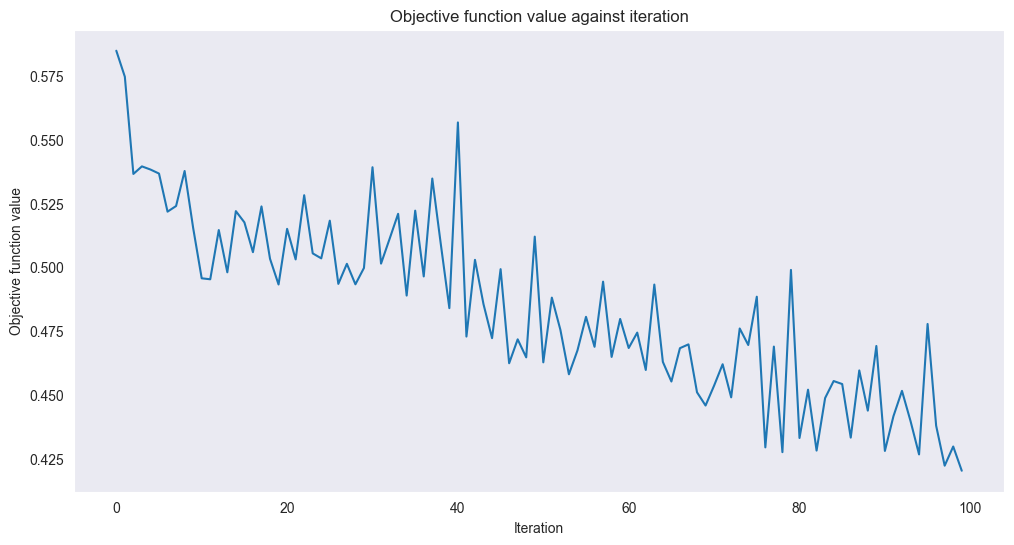

In [92]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(embedded_train, y_working)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [93]:
train_score_q4 = estimator_classifier.score(embedded_train, y_working)
test_score_q4 = estimator_classifier.score(embedded_test, y_held_out)

print(f"Quantum estimator QNN on the training dataset: {train_score_q4:.2f}")
print(f"Quantum estimator QNN on the test dataset:     {test_score_q4:.2f}")

Quantum estimator QNN on the training dataset: 0.55
Quantum estimator QNN on the test dataset:     0.49


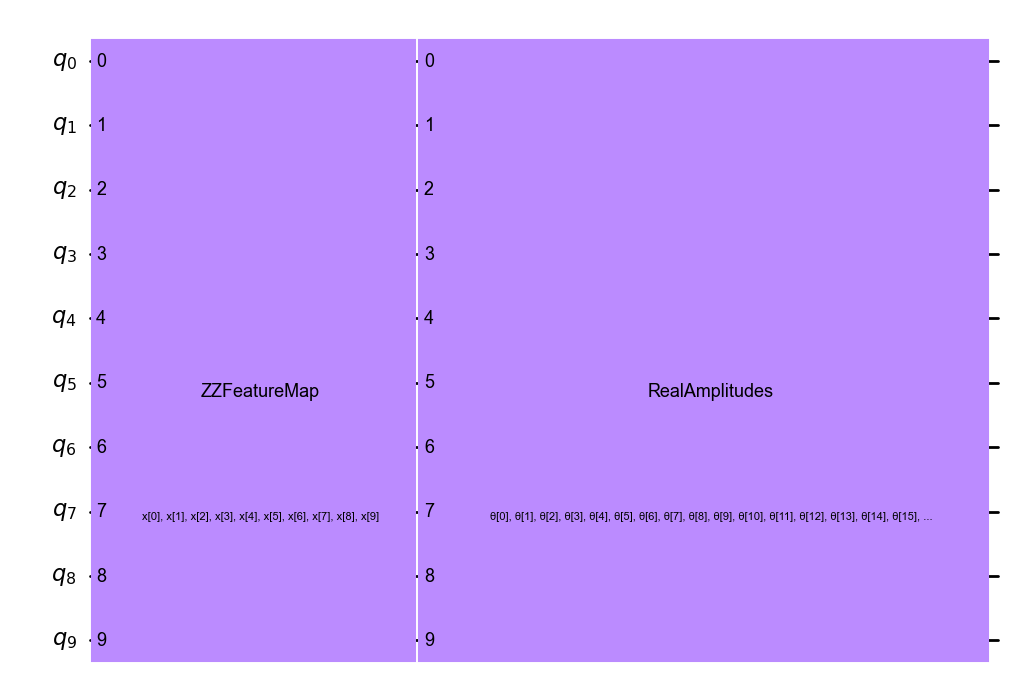

In [94]:
# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc_sampler = QNNCircuit(ansatz=RealAmplitudes(num_features, reps=1))
qc_sampler.draw("mpl", style="clifford")

In [95]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [96]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc_sampler,
    interpret=parity,
    output_shape=output_shape,
)

In [97]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=100), callback=callback_graph
)

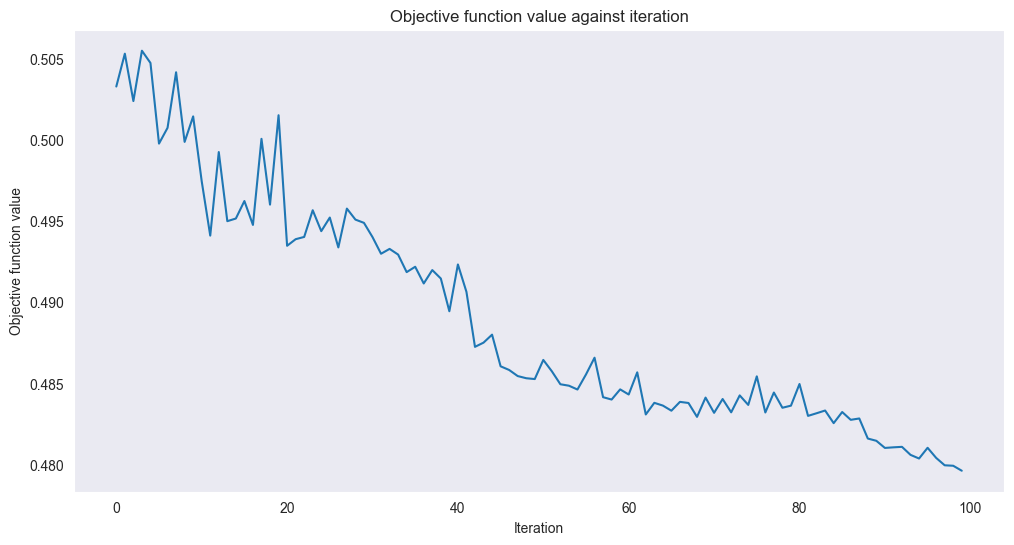

In [98]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(embedded_train, y_working)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [99]:
train_score_q4 = sampler_classifier.score(embedded_train, y_working)
test_score_q4 = sampler_classifier.score(embedded_test, y_held_out)

print(f"Quantum Sampler QNN on the training dataset: {train_score_q4:.2f}")
print(f"Quantum Sampler QNN on the test dataset:     {test_score_q4:.2f}")

Quantum Sampler QNN on the training dataset: 0.61
Quantum Sampler QNN on the test dataset:     0.57
